In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from default_func import extract_image_file_name_from_lidar_file_name

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
print(torch.cuda.is_available())

True


In [3]:
# Проверяем, доступны ли GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
from os.path import join
import glob
import json

root_path_train = '.\\camera_lidar_semantic_bboxes\\train\\'
# get the list of files in lidar directory
file_names_lidar_train = sorted(glob.glob(join(root_path_train, '*\\lidar\\cam_front_center\\*.npz')))

root_path_test = '.\\camera_lidar_semantic_bboxes\\test\\'
# get the list of files in lidar directory
file_names_lidar_test = sorted(glob.glob(join(root_path_test, '*\\lidar\\cam_front_center\\*.npz')))

file_names_photo_train = []

for file_name_lidar in file_names_lidar_train:
    seq_name = file_name_lidar.split('\\')[3]
    file_name_image = extract_image_file_name_from_lidar_file_name(file_name_lidar)
    file_name_image = join(root_path_train, seq_name, 'camera\\cam_front_center\\', file_name_image)
    file_names_photo_train.append(file_name_image)

file_names_photo_test = []

for file_name_lidar in file_names_lidar_test:
    seq_name = file_name_lidar.split('\\')[3]
    file_name_image = extract_image_file_name_from_lidar_file_name(file_name_lidar)
    file_name_image = join(root_path_test, seq_name, 'camera\\cam_front_center\\', file_name_image)
    file_names_photo_test.append(file_name_image)

with open('preprocessed_masks/train_list.json', 'r') as f:
    preprocessed_train_masks = json.load(f)

with open('preprocessed_masks/test_list.json', 'r') as f:
    preprocessed_test_masks = json.load(f)

In [5]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np

class UltraFastSegmentationDataset(Dataset):
    def __init__(self, image_files, preprocessed_mask_files, image_size=(300, 300)):
        self.image_files = image_files
        self.preprocessed_mask_files = preprocessed_mask_files
        self.image_size = image_size
        self.num_classes = 19

        # Transform для изображений (маски уже с resize)
        self.image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    def __len__(self):
        return len(self.image_files)
    
    def get_num_classes(self):
        return self.num_classes

    def __getitem__(self, idx):
        # Загружаем изображение
        img_path = self.image_files[idx]
        img = Image.open(img_path).convert("RGB")
        
        # Загружаем ПРЕДОБРАБОТАННУЮ маску (уже с resize)
        mask_path = self.preprocessed_mask_files[idx]
        mask_transformed = np.load(mask_path)
        
        # Преобразуем изображение
        img_transformed = self.image_transform(img)
        
        # Конвертируем маску в тензор
        mask_transformed = torch.from_numpy(mask_transformed).long()
        
        return img_transformed, mask_transformed
    
# Collate function для DataLoader
def collate_fn(batch):
    images = []
    masks = []
    
    for img, mask in batch:
        images.append(img)
        masks.append(mask)
    
    images = torch.stack(images, dim=0)
    masks = torch.stack(masks, dim=0)
    
    return images, masks

In [6]:
# 2. Создаем быстрые датасеты
train_dataset = UltraFastSegmentationDataset(
    file_names_photo_train, preprocessed_train_masks, (512, 512)
)
test_dataset = UltraFastSegmentationDataset(
    file_names_photo_test, preprocessed_test_masks, (512, 512)
)

# 3. Создаем DataLoader (теперь будет ОЧЕНЬ быстрый)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)

In [7]:
import numpy as np

# Функция для визуализации батча
def visualize_batch(images, masks, num_samples=4):
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, num_samples * 4))
    
    for i in range(num_samples):
        if i >= images.shape[0]:
            break
            
        # Денормализуем изображение
        img = images[i].permute(1, 2, 0).numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        
        # Маска
        mask = masks[i].numpy()
        
        axes[i, 0].imshow(img)
        axes[i, 0].set_title(f'Image {i}')
        axes[i, 0].axis('off')
        
        im = axes[i, 1].imshow(mask, cmap='tab20', vmin=0, vmax=train_dataset.get_num_classes()-1)
        axes[i, 1].set_title(f'Mask {i}')
        axes[i, 1].axis('off')
        plt.colorbar(im, ax=axes[i, 1])
    
    plt.tight_layout()
    plt.show()

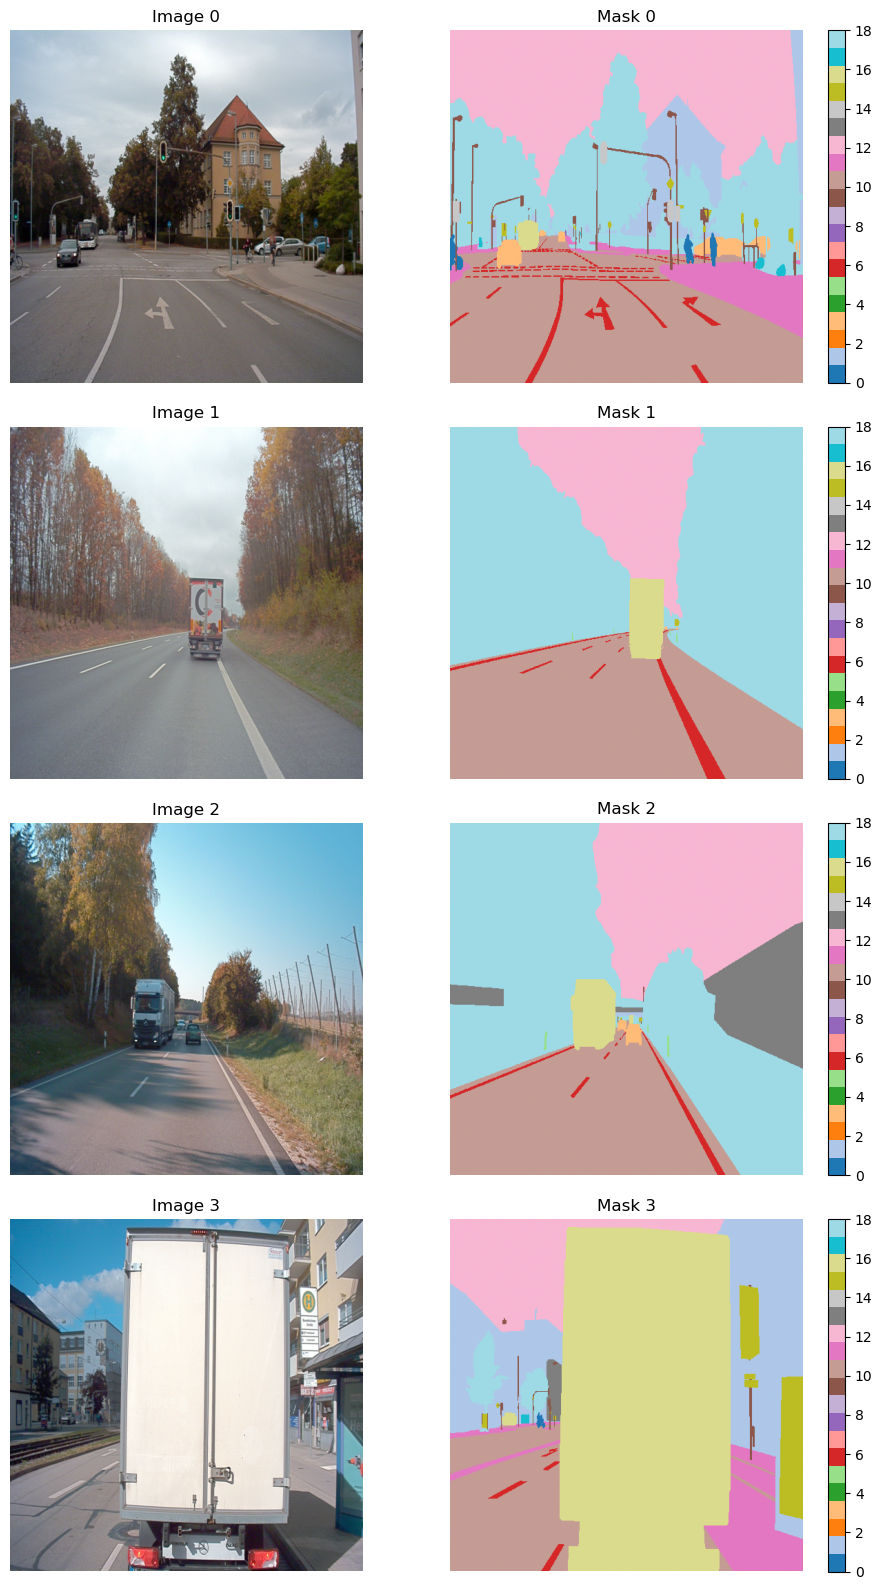

In [8]:
# Использование
for images, masks in train_loader:
    visualize_batch(images, masks)
    break

In [8]:
import torch
import torch.nn as nn
from torchvision.models import resnet50

class UNetWithResNet50(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        # Encoder - ResNet50
        backbone = resnet50(pretrained=pretrained)
        # Сохраняем промежуточные слои с правильными размерами
        self.initial_conv = backbone.conv1
        self.initial_bn = backbone.bn1
        self.initial_relu = backbone.relu
        self.initial_maxpool = backbone.maxpool  # /4
        
        self.encoder1 = backbone.layer1  # /4
        self.encoder2 = backbone.layer2  # /8
        self.encoder3 = backbone.layer3  # /16
        self.encoder4 = backbone.layer4  # /32
        
        # Decoder
        self.upconv4 = nn.ConvTranspose2d(2048, 1024, kernel_size=2, stride=2)
        self.decoder4 = self._make_decoder_block(2048, 1024)  # 1024 + 1024
        self.upconv3 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.decoder3 = self._make_decoder_block(1024, 512)   # 512 + 512
        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder2 = self._make_decoder_block(512, 256)    # 256 + 256
        self.upconv1 = nn.ConvTranspose2d(256, 64, kernel_size=2, stride=2)
        self.decoder1 = self._make_decoder_block(128, 64)     # 64 + 64
        
        # Final layers
        self.final_upsample = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.final_conv = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, num_classes, kernel_size=1)
        )
        
    def _make_decoder_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
    
    def forward(self, x):
        # Initial layers
        x0 = self.initial_conv(x)     # 64, H, W -> 64, H/2, W/2
        x0 = self.initial_bn(x0)
        x0 = self.initial_relu(x0)
        x1 = self.initial_maxpool(x0) # 64, H/2, W/2 -> 64, H/4, W/4
        # Encoder
        e1 = self.encoder1(x1)  # 256, H/4, W/4
        e2 = self.encoder2(e1)  # 512, H/8, W/8
        e3 = self.encoder3(e2)  # 1024, H/16, W/16
        e4 = self.encoder4(e3)  # 2048, H/32, W/32
        
        # Decoder with skip connections
        d4 = self.upconv4(e4)   # 1024, H/16, W/16
        d4 = torch.cat([d4, e3], dim=1)  # 2048
        d4 = self.decoder4(d4)  # 1024
        
        d3 = self.upconv3(d4)   # 512, H/8, W/8
        d3 = torch.cat([d3, e2], dim=1)  # 1024
        d3 = self.decoder3(d3)  # 512
        
        d2 = self.upconv2(d3)   # 256, H/4, W/4
        d2 = torch.cat([d2, e1], dim=1)  # 512
        d2 = self.decoder2(d2)  # 256
        
        d1 = self.upconv1(d2)   # 64, H/2, W/2
        d1 = torch.cat([d1, x0], dim=1)  # 128
        d1 = self.decoder1(d1)  # 64
        
        # Final upsampling
        out = self.final_upsample(d1)  # 32, H, W
        out = self.final_conv(out)     # num_classes, H, W
        
        return out

In [9]:
# Гиперпараметры
num_classes = 19
learning_rate = 1e-4  # Уменьшили learning rate
weight_decay = 1e-4     # Weight decay для AdamW

In [10]:
# Инициализация модели
model = UNetWithResNet50(num_classes=num_classes)
model = model.to(device)

C:\Users\neUral\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\neUral\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
import torch
import numpy as np
from tqdm import tqdm

def calculate_class_weights(dataloader, num_classes=19, device='cuda'):
    """Вычисляет веса классов на основе частоты пикселей"""
    pixel_count = torch.zeros(num_classes, device=device)
    total_pixels = 0
    
    with torch.no_grad():
        for images, masks in tqdm(dataloader, desc="Preprocessing masks"):
            masks = masks.to(device)
            for class_id in range(num_classes):
                pixel_count[class_id] += (masks == class_id).sum()
            total_pixels += masks.numel()
    
    # Frequency-based weighting
    class_freq = pixel_count / total_pixels
    class_weights = 1.0 / (class_freq + 1e-6)  # избегаем деления на 0
    class_weights = class_weights / class_weights.sum()  # нормализуем
    
    return class_weights.cpu()

# Использование
class_weights = calculate_class_weights(train_loader, num_classes=19)
print(class_weights)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights.to(device))

tensor([6.6759e-02, 7.4535e-04, 5.8502e-02, 1.4638e-03, 4.0718e-01, 9.5851e-03,
        7.2199e-03, 2.6133e-01, 5.4994e-02, 9.6064e-03, 3.4003e-04, 2.7777e-03,
        3.2883e-04, 6.4901e-03, 8.3840e-02, 1.0784e-02, 3.1417e-03, 1.4554e-02,
        3.5410e-04])


In [16]:
# Функция потерь и оптимизатор AdamW
# criterion = nn.CrossEntropyLoss()
criterion = torch.nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.AdamW(model.parameters(), 
                       lr=learning_rate, 
                       weight_decay=weight_decay)  # AdamW вместо Adam

# Scheduler для динамического изменения learning rate
scheduler = ReduceLROnPlateau(optimizer, 
                             mode='min',          # Минимизируем loss
                             factor=0.5,          # Умножаем LR на 0.5
                             patience=5,          # Ждем 5 эпох без улучшения
                             min_lr=1e-7)         # Минимальный LR

In [ ]:
checkpoint = torch.load('.\\models\\pitstop_unet_rn50.pth', map_location=device)
    
# Загружаем состояние модели
model.load_state_dict(checkpoint['model_state_dict'])

optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# После загрузки оптимизатора
for param_group in optimizer.param_groups:
    param_group['lr'] = 3e-5  # Новое значение learning rate для fine-tuning

In [17]:
num_epochs = 40
history = []
history_test = []

In [24]:
from tqdm import tqdm

# Цикл обучения
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    
    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1} Train", leave=False):
        images = images.to(device)
        masks = masks.to(device)
        
        # Forward pass
        outputs = model(images)
        
        # Вычисление потерь
        loss = criterion(outputs, masks)
        
        # Backward pass и оптимизация
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    # Валидация
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in tqdm(test_loader, desc=f"Epoch {epoch+1} Test", leave=False):
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            
            loss = criterion(outputs, masks)
            val_loss += loss.item()
    
    avg_train_loss = train_loss / len(train_loader)
    history.append(avg_train_loss)
    avg_val_loss = val_loss / len(test_loader)
    history_test.append(avg_val_loss)
    
    # Обновляем scheduler
    scheduler.step(avg_val_loss)
    
    # Текущий learning rate
    current_lr = optimizer.param_groups[0]['lr']
    
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {avg_train_loss:.4f}, '
          f'Val Loss: {avg_val_loss:.4f}, '
          f'LR: {current_lr:.2e}')

Epoch [1/40], Train Loss: 0.2510, Val Loss: 0.4831, LR: 1.00e-04


Epoch [2/40], Train Loss: 0.2577, Val Loss: 0.4286, LR: 1.00e-04


Epoch [3/40], Train Loss: 0.2468, Val Loss: 0.5027, LR: 1.00e-04


Epoch [4/40], Train Loss: 0.2198, Val Loss: 0.4540, LR: 1.00e-04


Epoch [5/40], Train Loss: 0.2078, Val Loss: 0.4877, LR: 1.00e-04


KeyboardInterrupt: 

In [48]:
checkpoint = {
    'epoch': epoch,  # количество выполненных эпох
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': avg_val_loss,  # значение функции потерь
    # можно добавлять и другие метрики, нужные для ваших экспериментов
}
torch.save(checkpoint, '.\\models\\pitstop_unet_rn50.pth')

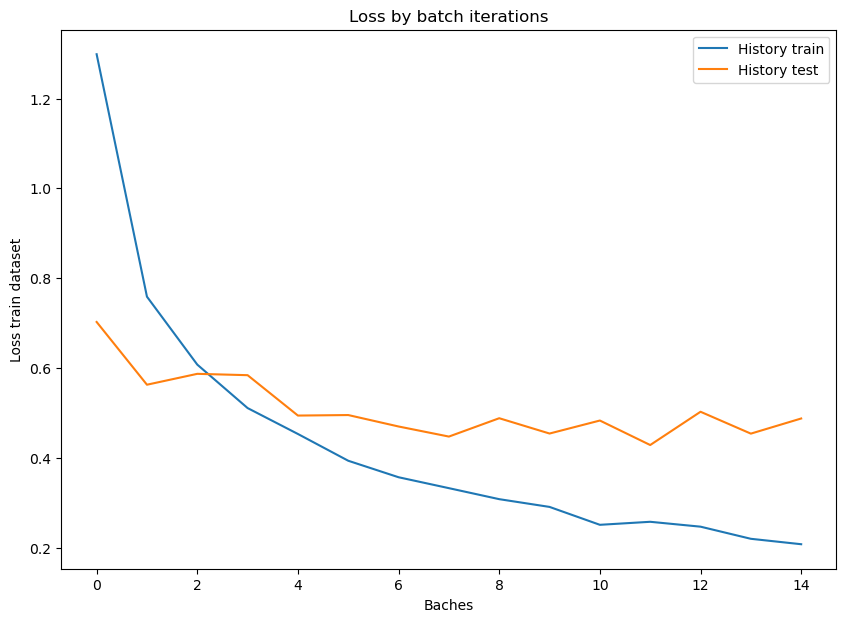

In [25]:
plt.figure(figsize=(10, 7))
plt.plot(history, label = 'History train')
plt.plot(history_test, label = 'History test')
plt.title('Loss by batch iterations')
plt.ylabel('Loss train dataset')
plt.xlabel('Baches')
#plt.yscale('log')
#plt.xscale('log')
plt.legend()

plt.show()

In [6]:
from os.path import join
import glob

root_path_train = '.\\camera_lidar_semantic_bboxes\\special\\'
# get the list of files in lidar directory
file_names_lidar_train = sorted(glob.glob(join(root_path_train, '*\\lidar\\cam_front_center\\*.npz')))

file_names_photo_train_vis = []

for file_name_lidar in file_names_lidar_train:
    seq_name = file_name_lidar.split('\\')[3]
    file_name_image = extract_image_file_name_from_lidar_file_name(file_name_lidar)
    file_name_image = join(root_path_train, seq_name, 'camera\\cam_front_center\\', file_name_image)
    file_names_photo_train_vis.append(file_name_image)

start = 0
end = 0

for i in range(len(file_names_photo_train)):
    if file_names_photo_train[i][37:] == file_names_photo_train_vis[0][39:]:
        start = i
    if file_names_photo_train[i][37:] == file_names_photo_train_vis[-1][39:]:
        end = i

# 2. Создаем быстрые датасеты
special_dataset = UltraFastSegmentationDataset(
    file_names_photo_train_vis, preprocessed_train_masks[start:end], (512, 512)
)

# 3. Создаем DataLoader (теперь будет ОЧЕНЬ быстрый)
special_loader = DataLoader(special_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)

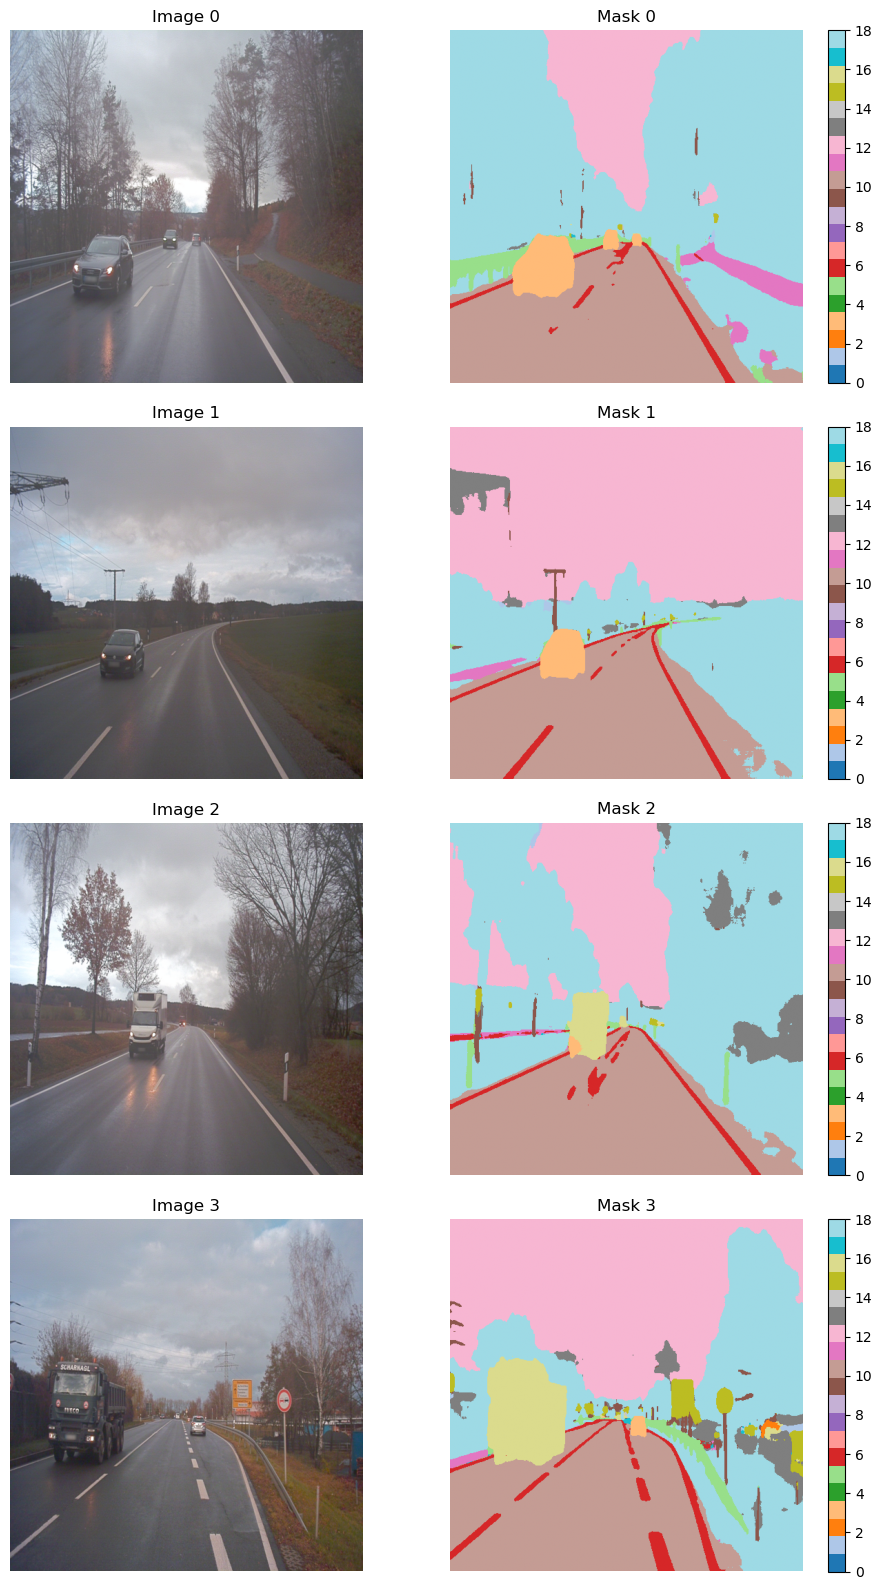

In [26]:
import torch.nn.functional as F

model.eval()
with torch.no_grad():
    for images, masks in test_loader:
        images = images.to(device)
        masks = masks.to(device)
        
        outputs = model(images)

        predictions = torch.argmax(F.softmax(outputs, dim=1), dim=1)

        visualize_batch(images.cpu(), predictions.cpu())

        break

In [22]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix

class SegmentationMetrics:
    def __init__(self, num_classes=19, device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.num_classes = num_classes
        self.device = device
        
    def _get_confusion_matrix(self, pred, target):
        """Вычисляет матрицу confusion для батча"""
        pred = pred.flatten()
        target = target.flatten()
        mask = (target >= 0) & (target < self.num_classes)
        return confusion_matrix(
            target[mask].cpu().numpy(), 
            pred[mask].cpu().numpy(), 
            labels=list(range(self.num_classes))
        )
    
    def compute_iou(self, cm):
        """Вычисляет IoU из матрицы confusion"""
        intersection = np.diag(cm)
        union = cm.sum(axis=1) + cm.sum(axis=0) - intersection
        iou = intersection / (union + 1e-10)
        return iou
    
    def compute_precision_recall_f1(self, cm):
        """Вычисляет Precision, Recall и F1-score"""
        tp = np.diag(cm)
        fp = cm.sum(axis=0) - tp
        fn = cm.sum(axis=1) - tp
        
        precision = tp / (tp + fp + 1e-10)
        recall = tp / (tp + fn + 1e-10)
        f1 = 2 * (precision * recall) / (precision + recall + 1e-10)
        
        return precision, recall, f1
    
    def compute_metrics(self, predictions, targets):
        """
        Вычисляет все метрики для батча предсказаний
        
        Args:
            predictions: torch.Tensor [batch_size, H, W] с предсказанными классами
            targets: torch.Tensor [batch_size, H, W] с истинными метками
        
        Returns:
            dict: Словарь со всеми вычисленными метриками
        """
        # Проверяем размерности
        assert predictions.shape == targets.shape, "Размеры predictions и targets должны совпадать"
        
        # Инициализируем общую матрицу confusion
        total_cm = np.zeros((self.num_classes, self.num_classes), dtype=np.int64)
        
        # Обрабатываем каждый элемент батча
        for i in range(predictions.shape[0]):
            pred = predictions[i]
            target = targets[i]
            cm = self._get_confusion_matrix(pred, target)
            total_cm += cm
        
        # Вычисляем все метрики
        iou_per_class = self.compute_iou(total_cm)
        precision_per_class, recall_per_class, f1_per_class = self.compute_precision_recall_f1(total_cm)
        
        # Вычисляем средние значения
        miou = np.nanmean(iou_per_class)
        mean_precision = np.nanmean(precision_per_class)
        mean_recall = np.nanmean(recall_per_class)
        mean_f1 = np.nanmean(f1_per_class)
        
        # Вычисляем Pixel Accuracy
        total_pixels = total_cm.sum()
        correct_pixels = np.diag(total_cm).sum()
        pixel_accuracy = correct_pixels / total_pixels
        
        # Mean Pixel Accuracy
        mean_pixel_accuracy = np.nanmean(np.diag(total_cm) / (total_cm.sum(axis=1) + 1e-10))
        
        return {
            'miou': miou,
            'iou_per_class': iou_per_class,
            'pixel_accuracy': pixel_accuracy,
            'mean_pixel_accuracy': mean_pixel_accuracy,
            'mean_precision': mean_precision,
            'mean_recall': mean_recall,
            'mean_f1': mean_f1,
            'precision_per_class': precision_per_class,
            'recall_per_class': recall_per_class,
            'f1_per_class': f1_per_class,
            'confusion_matrix': total_cm
        }

In [27]:
import torch.nn.functional as F

# Инициализация
metrics_calculator = SegmentationMetrics(num_classes=19)

# Предположим, у нас есть модель и данные
# model = YourSegmentationModel()
# dataloader = YourDataLoader()

all_metrics = []

for batch_idx, (images, targets) in enumerate(test_loader):
    with torch.no_grad():
        images = images.to(device)
        # Получаем предсказания (вероятности)
        outputs = model(images)
        
        # Преобразуем в классы [batch_size, H, W]
        predictions = torch.argmax(F.softmax(outputs, dim=1), dim=1)
        
        # Вычисляем метрики для батча
        metrics = metrics_calculator.compute_metrics(predictions.cpu(), targets)
        all_metrics.append(metrics)
        
        # Можно выводить промежуточные результаты
        if batch_idx % 10 == 0:
            print(f"Batch {batch_idx}: mIoU = {metrics['miou']:.4f}, PA = {metrics['pixel_accuracy']:.4f}")

# Усредняем метрики по всем батчам
final_metrics = {
    'miou': np.mean([m['miou'] for m in all_metrics]),
    'pixel_accuracy': np.mean([m['pixel_accuracy'] for m in all_metrics]),
    'mean_pixel_accuracy': np.mean([m['mean_pixel_accuracy'] for m in all_metrics]),
    'mean_f1': np.mean([m['mean_f1'] for m in all_metrics])
}

print("\nFinal Metrics:")
print(f"Mean IoU: {final_metrics['miou']:.4f}")
print(f"Pixel Accuracy: {final_metrics['pixel_accuracy']:.4f}")
print(f"Mean Pixel Accuracy: {final_metrics['mean_pixel_accuracy']:.4f}")
print(f"Mean F1-Score: {final_metrics['mean_f1']:.4f}")

Batch 0: mIoU = 0.3722, PA = 0.9312
Batch 10: mIoU = 0.3585, PA = 0.8777
Batch 20: mIoU = 0.4184, PA = 0.9340
Batch 30: mIoU = 0.3892, PA = 0.9107
Batch 40: mIoU = 0.3578, PA = 0.9703
Batch 50: mIoU = 0.3929, PA = 0.8936
Batch 60: mIoU = 0.3783, PA = 0.9053

Final Metrics:
Mean IoU: 0.3488
Pixel Accuracy: 0.9169
Mean Pixel Accuracy: 0.4849
Mean F1-Score: 0.4104


In [32]:
def print_class_metrics(metrics, class_names=None):
    """Печатает метрики для каждого класса"""
    if class_names is None:
        class_names = [f'Class {i}' for i in range(19)]
    
    print("\nMetrics per class:")
    print(f"{'Class':<15} {'IoU':<8} {'Precision':<10} {'Recall':<8} {'F1':<8}")
    print("-" * 50)
    
    for i, (iou, prec, rec, f1) in enumerate(zip(
        metrics['iou_per_class'], 
        metrics['precision_per_class'], 
        metrics['recall_per_class'], 
        metrics['f1_per_class']
    )):
        print(f"{class_names[i]:<15} {iou:.4f}   {prec:.4f}     {rec:.4f}   {f1:.4f}")

class_names = ['bicycle', 'building', 'bus', 'car', 'crosswalk', 'fence', 'line', 'motorcycle', 'person', 'pole', 'road', 'sidewalk', 'sky', 'terrain', 'traffic_light', 'traffic_sign', 'truck', 'unknown', 'vegetatio']

# Использование
print_class_metrics(all_metrics, class_names)


Metrics per class:
Class           IoU      Precision  Recall   F1      
--------------------------------------------------


TypeError: list indices must be integers or slices, not str